In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from CustomDataset import PreloadedDataset
import matplotlib.pyplot as plt

c:\Users\joeag\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

c:\Users\joeag\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


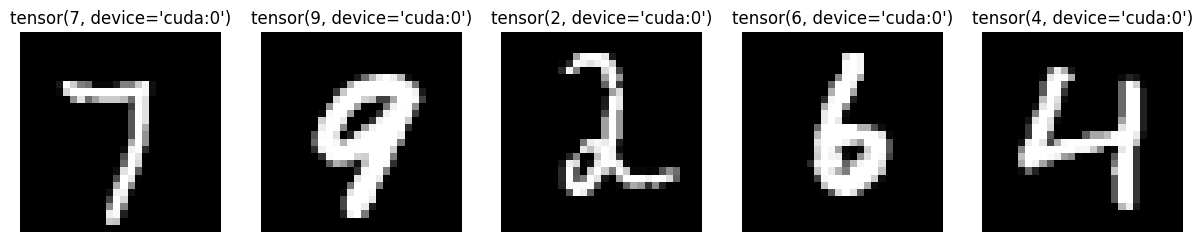

In [3]:
VAL_RATIO = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # Scale(255.0),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=20, translate=(0.15,0.15), scale=(0.90,1.10)),
])

dataset = datasets.MNIST(root="../../../datasets/", train=True, transform=transforms.ToTensor(), download=True)
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
INPUT_SHAPE = train_dataset[0][0].shape
NUM_CLASSES = 10

# Display some images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(F.sigmoid(train_dataset[i][0]).cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(train_dataset[i][1])
    ax.axis("off")

plt.show()

In [422]:
class Layer(nn.Module):
    def __init__(self, in_features, out_features, activation='sigmoid', lr=0.1, lateral=True):
        super(Layer, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.lr = lr
        self.has_lateral = lateral

        self.bottom_up = nn.Linear(in_features, out_features, bias=False)
        # self.bottom_up.weight.data = F.sigmoid(self.bottom_up.weight.data)
        self.top_down = nn.Linear(out_features, in_features, bias=True)
        # self.top_down.weight.data = F.sigmoid(self.top_down.weight.data)
        if lateral:
            self.lateral = nn.Linear(out_features, out_features, bias=False)
            self.lateral.weight.data = F.sigmoid(self.lateral.weight.data)


        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = None

        self.error = None
        self.belief = None

    def update_params(self, lr=0.01, reg=0.1):
        self.bottom_up.weight.data += (lr * (1.0-reg) / self.belief.shape[0]) * (self.belief.t() @ self.error)
        self.top_down.weight.data += (lr * (1.0-reg) / self.belief.shape[0]) * (self.error.t() @ self.belief)
        if reg > 0.0:
            self.bottom_up.weight.data -= lr * reg * self.bottom_up.weight.data
            self.top_down.weight.data -= lr * reg * self.top_down.weight.data

        self.top_down.bias.data += lr * self.error.mean(dim=0)

        if self.has_lateral:
            self.lateral.weight.data += (lr/self.belief.shape[0]) * self.belief.t() @ self.belief

    def init_state(self, batch_size, random=True, device='cpu'):
        if random:
            self.error = torch.randn(batch_size, self.in_features).to(device)
            self.belief = torch.randn(batch_size, self.out_features).to(device)
        else:
            self.error = torch.zeros(batch_size, self.in_features).to(device)
            self.belief = torch.zeros(batch_size, self.out_features).to(device)

        if self.activation is not None:
            self.belief = self.activation(self.belief)
        
    def forward(self, bottom_up_belief, top_down_error=None):

        self.error += self.lr * (bottom_up_belief - self.activation(self.top_down(self.belief)))

        self.belief += self.lr * self.bottom_up(self.error)
        if self.has_lateral:
            self.belief -= self.lr * self.lateral(self.belief)
        if top_down_error is not None:
            self.belief -= self.lr * top_down_error

    

    

In [423]:
class Model(nn.Module):
    def __init__(self, sizes, activation='sigmoid', lr=0.1, steps=20, lateral=True):
        super(Model, self).__init__()
        self.sizes = sizes
        self.depth = len(sizes)
        self.activation = activation
        self.lr = lr
        self.steps = steps

        self.layers = nn.ModuleList()
        for i in range(self.depth-1):
            self.layers.append(Layer(self.sizes[i], self.sizes[i+1], self.activation, self.lr, lateral=lateral))

    def update_params(self, lr=0.01, reg=0.1):
        for i in range(self.depth-1):
            self.layers[i].update_params(lr, reg)

    def update(self, x, y=None):
        self.layers[0](x)
        for i in range(1, self.depth-1):
            if i < self.depth-2:
                self.layers[i](self.layers[i-1].belief, self.layers[i+1].error)
            else:
                self.layers[i](self.layers[i-1].belief)  # pass noise as td_error?
                if y is not None:
                    self.layers[i].belief = y

    def forward(self, x, y=None, steps=None):
        if steps is None:
            steps = self.steps

        for i in range(self.depth-1):
            self.layers[i].init_state(x.shape[0], device=x.device)
        
        for step_i in range(steps):
            self.update(x, y)

    @property
    def output(self):
        return self.layers[-1].belief

    @property
    def error(self):
        error = 0
        for i in range(self.depth-1):
            error += self.layers[i].error.square().mean()
        return error / (self.depth-1)



In [424]:
def eval(model, dataset, batch_size=256):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    for x, y in dataloader:
        x = x.flatten(start_dim=1)
        with torch.no_grad():
            model(x)
        y_pred = model.output
        loss += F.cross_entropy(y_pred, y, reduction='sum').item()
    return loss / len(dataset)


def train(model, train_dataset, val_dataset, batch_size, lr, reg, epochs, errors, losses, steps=20):

    for epoch in range(epochs):
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        error = 0
        loop = tqdm(train_dataloader, leave=False, total=len(train_dataloader))
        if epoch > 0:
            loop.set_description('Epoch {}/{}'.format(epoch, epochs))
            loop.set_postfix(loss=losses[-1], error=errors[-1])
        for x, y in loop:
            x = x.flatten(start_dim=1)
            y = F.one_hot(y, num_classes=10).float()
            with torch.no_grad():
                model(x, y, steps=steps)
            y_pred = model.output
            model.update_params(lr, reg)
            error += model.error

        loss = eval(model, val_dataset)
        errors.append(error/len(train_dataloader))
        losses.append(loss/len(train_dataloader))

    return errors, losses

In [425]:
LATERAL = False
model = Model([784, 100, 10], lateral=LATERAL, lr=0.1, activation='sigmoid').to(device)
errors = []
losses = []

In [455]:
num = 10000
x = train_dataset[0:num][0].flatten(start_dim=1)
y = F.one_hot(train_dataset[0:num][1], num_classes=10).float()

with torch.no_grad():
    model(x,y=y, steps=10)
print(model.error.item())
model.update_params(lr=3e-4, reg=0.1)
model.layers[0].bottom_up.weight.data.abs().max(), model.layers[0].top_down.weight.data.abs().max()


1.9531033039093018


(tensor(0.0535, device='cuda:0'), tensor(0.1168, device='cuda:0'))

In [758]:
BATCH_SIZE=512
LR=1e-3
EPOCHS=20
STEPS=2
REG=0.2
errors, losses = train(model, train_dataset, val_dataset, BATCH_SIZE, LR, REG, EPOCHS, errors, losses, STEPS)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(errors)
ax[0].set_title('Errors')
ax[1].plot(losses)
ax[1].set_title('Losses')
plt.show()



KeyboardInterrupt: 